# Импортируем необходимые библиотеки 

In [7]:
import json
import pandas as pd
import re
import random
import time
import numpy as np
import nltk
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

######## METRICS
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# matplotlib
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Функции, которые будут использоваться:
    - preprocess_reviews - для удаления из отзывов всех лишних символов
    - lemmatize - для лемматизации слов

In [8]:
from nltk import word_tokenize   
from nltk.stem import WordNetLemmatizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [9]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()

In [10]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
stop_words = stopwords.words('english')
def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    return reviews
def lemmatize(str_):
    lst = str_.split(" ")
    lst_new = []
    for i in lst:
        if i not in stop_words:     
            new = porter.stem(i)
            lst_new.append (new)
    return ' '.join(lst_new)

# Главная функция (classify_it), в которую подставляется месторасположение файлов.

In [11]:
from sklearn.utils import shuffle

def prepare_dataset(filename):
    i = 0
    reviews_lst_good= []
    reviews_lst_bad = []

    #набираем список хороших/плохих отзывов, не более 75000 в каждом из списков
    with open(filename, 'r') as f:
            for line in f:
                if json.loads(line)['overall'] > 3 and len(reviews_lst_good)<=500000:
                    reviews_lst_good.append (json.loads(line))

                elif json.loads(line)['overall'] < 3 and len(reviews_lst_bad)<=500000:
                    reviews_lst_bad.append (json.loads(line))

                if len(reviews_lst_good) + len (reviews_lst_bad) == 1000000:
                    break
    
    # перемешиваем список (внутри элементы одного класса)
    shuffle(reviews_lst_good,random_state=241)  
    shuffle(reviews_lst_bad,random_state=241)  
    
    # создаём template для сохранения конечных отзывов
    reviewText_lst = []
    mark_lst = []
    
    
    # где будем уменьшать количество отзывов, чтобы их было равное количество
    if len (reviews_lst_bad) < len(reviews_lst_good):
        count_otz = len (reviews_lst_bad)
    else:
        count_otz = len (reviews_lst_good)
        
    
    # i -- это СЛОВАРЬ!        
    # обрезаем хороший и наполняем уже итоговый список
    for i in reviews_lst_good[:count_otz]:
        reviewText_lst.append (i['reviewText']) # можно прописать лемматизацию lemmatize()
        mark_lst.append (1)
    print ('Good: ',len(reviews_lst_good[:count_otz]))

    # обрезаем плохие
    for i in reviews_lst_bad[:count_otz]:
        reviewText_lst.append (i['reviewText'])
        mark_lst.append (0) # -1
    print ('Bad: ',len(reviews_lst_bad[:count_otz]))

    return reviewText_lst, mark_lst
    
def classify_it(filename, reviewText_lst, mark_lst):  
    
    # выборки готовы к передачи в модель
    reviews_train = reviewText_lst
    y = mark_lst
    
    # очищаем отзывы от лишних символов
    reviews_train_clean = preprocess_reviews(reviews_train)
    
#     print (reviews_train_clean[:4])
    
    # делим выборку на тестовую и обучающую
    X_train, X_val, y_train, y_val = train_test_split(
        reviews_train_clean, y, train_size = 0.75, random_state=241
    )  
    
    # столбец ответов 
    

    print ('Подбор параметра для: ', filename[:-5])
    print ('    ')
    best_c_dict = {} # модель сама ищет лучший c и его результаты подбирает в итоге
    c_list = []
    result_c_list = []      
   
    time_lst_fit = []
    time_frcst_lst = []
    result_time_fit_lst = []
    result_time_frcst_lst = []
    
    # определяем, где алгоритму необходимо искать С
    
    # 0.0001,0.001,0.01,0.05,0.25,0.1,
    
    grid = [0.001,0.01,0.05,0.1,0.25,1,5,6,8,10,100,1000]
    
    
    print ('Бинаризируем столбец признаков')
    # бинаризируем столбец признаков
    cv = TfidfVectorizer(min_df=4, decode_error='replace', encoding='utf-8', norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
    X = cv.fit_transform(X_train)
    X_test = cv.transform(X_val)

    print ('c подбираем')

    
    # итерируемся и подбираем параметр, используя Accuracy
    for c in grid:
        
        final_model = LogisticRegression(C=c, solver= 'sag',random_state=241)
        
        startTime = time.time()
        final_model.fit(X, y_train) ######
        resultTime = time.time() - startTime
        time_lst_fit.append (resultTime)
        
        startTime = time.time()
        y_pred = final_model.predict(X_test) #####
        resultTime = time.time() - startTime
        time_frcst_lst.append (resultTime)
        
        print ("Accuracy for C=%s: %s" 
               % (c, accuracy_score(y_val, y_pred)))
        
        c_list.append (c)
        result_c_list.append (accuracy_score(y_val, y_pred))
        best_c_dict [c] = accuracy_score(y_val, y_pred)
        
    
    # записываем результаты подбора коэффициента c
    result_с = pd.DataFrame()
    result_с['c'] = c_list
    result_с ['result_acc'] = result_c_list
    result_с['fit_time'] = time_lst_fit
    result_с['forecast_time'] = time_frcst_lst
    result_с.to_csv (filename[:-5]+'_podbor_c_v1.csv', index=False)
    ###########################################################################
    
    inverse = [(value, key) for key, value in best_c_dict.items()]
    print ('The best C is ', max(inverse)[1])
    
    
    ### строим предсказание с лучшим c ++ считаем потраченное время
    final_model_last = LogisticRegression(C=max(inverse)[1], solver= 'sag',random_state=241)
    final_model_last.fit(X, y_train)
    y_pred_last = final_model_last.predict(X_test)
    ################

    # смотрим на метрики 
    print ("Final Accuracy: %s" 
           % accuracy_score(y_val
                            , y_pred_last))
    
    print('confusion_matrix')
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_val, y_pred_last)
    print(confusion_matrix)
    
    print ('classification_report')
    print(classification_report(y_val, y_pred_last))
    
    
    print ('roc crivai')
    

    logit_roc_auc = roc_auc_score(y_val, y_pred_last)
    fpr, tpr, thresholds = roc_curve(y_val, final_model_last.predict_proba(X_test)[:,1])
    plt.figure()
    
    
    data = {'fpr': fpr, 'tpr': tpr}
    df = pd.DataFrame.from_dict(data)
    df.to_csv (filename[:-5]+'_roc_crivai_v1.csv', index=False)
    
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    
    # выделяем слова, которые обладают самым большим весом
    feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model_last.coef_[0]
        )
    }
    
    
    w_lst = []
    we_lst = []
    
    for best_positive in sorted(
        feature_to_coef.items(), 
        key=lambda x: x[1], 
        reverse=True)[:25]:
        w_lst.append (best_positive[0])
        we_lst.append (best_positive[1])
    
    
    for best_negative in sorted(
        feature_to_coef.items(), 
        key=lambda x: x[1])[:25]:
#         print (best_negative)
        w_lst.append (best_negative[0])
        we_lst.append (best_negative[1])
        
    df_words = pd.DataFrame.from_dict({'words':w_lst,'weights':we_lst})
    
    df_words.to_excel(filename[:-5]+'_words_v1.xlsx', index=False)
    
    print (df_words)
    
    del reviewText_lst
    del X
    del X_test
    gc.collect()

# Меняем расположение папки, где находятся наборы данных и запускаем все функции

Health_and_Personal_Care_5
   
Good:  33300
Bad:  33300
Подбор параметра для:  /Volumes/GoogleDrive/Мой диск/Work/Experiment/Health_and_Personal_Care_5
    
Бинаризируем столбец признаков
c подбираем
Accuracy for C=0.001: 0.7786186186186186
Accuracy for C=0.01: 0.803003003003003
Accuracy for C=0.05: 0.8341141141141141
Accuracy for C=0.1: 0.8452852852852852
Accuracy for C=0.25: 0.8600600600600601
Accuracy for C=1: 0.8711711711711712
Accuracy for C=5: 0.8739339339339339
Accuracy for C=6: 0.8727327327327328
Accuracy for C=8: 0.8721921921921922
Accuracy for C=10: 0.8705105105105105


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for C=100: 0.8470870870870871
Accuracy for C=1000: 0.832012012012012
The best C is  5
Final Accuracy: 0.8739339339339339
confusion_matrix
[[7272 1021]
 [1078 7279]]
classification_report
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      8293
           1       0.88      0.87      0.87      8357

   micro avg       0.87      0.87      0.87     16650
   macro avg       0.87      0.87      0.87     16650
weighted avg       0.87      0.87      0.87     16650

roc crivai


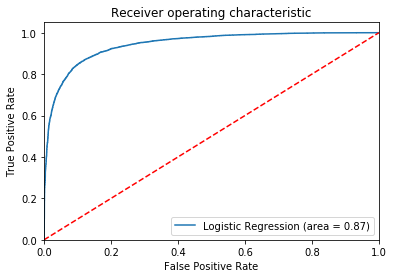

             words    weights
0            great  10.215955
1          pleased   9.421076
2           highly   9.344271
3          perfect   8.435245
4            helps   8.325291
5             easy   8.277812
6        excellent   7.966311
7             love   7.762384
8             best   7.241436
9       complaints   6.890553
10           works   6.836869
11         amazing   6.526150
12            glad   6.520608
13         awesome   6.472823
14       wonderful   6.226949
15           years   6.123559
16            good   5.879691
17           happy   5.779272
18          stores   5.731069
19          allows   5.636653
20       satisfied   5.558774
21          amazed   5.533047
22            beat   5.431249
23         cayenne   5.367185
24           loves   5.312136
25             not -13.229561
26    disappointed  -9.412525
27           waste  -9.306422
28   unfortunately  -9.245478
29           didnt  -9.233623
30           worst  -8.276315
31        returned  -7.951692
32   disap

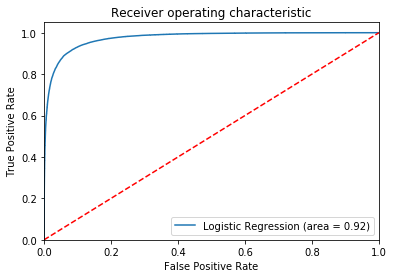

             words    weights
0            great  11.333175
1        excellent  10.748283
2          perfect  10.097267
3           superb   9.411044
4          classic   9.049486
5        complaint   8.872956
6        perfectly   7.915476
7        wonderful   7.632068
8             best   7.622978
9         favorite   7.590933
10          highly   7.540447
11             gem   7.468843
12       hilarious   7.285839
13          hooked   7.262793
14       fantastic   7.190124
15      refreshing   7.178881
16         awesome   7.151627
17         amazing   6.960160
18     wonderfully   6.892683
19            love   6.886009
20             fun   6.843543
21      pleasantly   6.776592
22       brilliant   6.752638
23         enjoyed   6.716455
24     outstanding   6.592949
25           worst -19.055502
26           waste -17.015588
27          boring -15.787035
28          wasted -13.320483
29          poorly -13.252433
30        terrible -13.215365
31           awful -12.584290
32  disapp

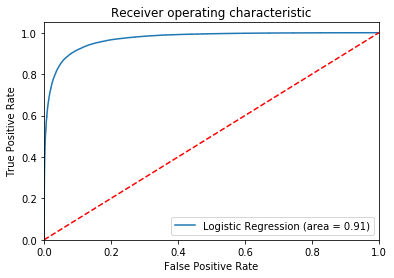

             words    weights
0            great  12.966780
1        excellent  11.546911
2          perfect  10.938669
3           highly  10.581273
4             beat  10.543258
5          pleased  10.305746
6        complaint   9.689810
7        perfectly   8.983284
8             best   8.847838
9          amazing   8.696010
10      complaints   8.676197
11       satisfied   8.663046
12      flawlessly   8.540812
13        hesitate   8.496801
14            love   8.445383
15      pleasantly   8.242779
16           happy   8.045979
17            easy   8.041780
18           minor   7.907037
19       fantastic   7.646859
20           worry   7.522440
21        drawback   7.299283
22          stores   7.264714
23         boxwave   7.246643
24            glad   7.186902
25        returned -16.744710
26       returning -16.644624
27   disappointing -14.424575
28    unacceptable -14.165976
29          return -14.152304
30         useless -13.648214
31             not -13.608083
32        

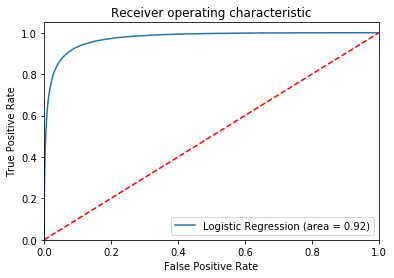

             words    weights
0         klausner  20.121698
1       refreshing  12.766045
2       pleasantly  11.993572
3        excellent  10.328179
4        complaint   9.895391
5            great   9.612392
6          enjoyed   9.379182
7            loved   8.986383
8          quibble   8.897004
9       delightful   8.840650
10     fascinating   8.722260
11      disappoint   8.494073
12          hooked   8.468756
13         amazing   8.327721
14          highly   8.225959
15     beautifully   8.189576
16       hilarious   8.144782
17       wonderful   7.821375
18     wonderfully   7.746719
19      invaluable   7.676339
20       fantastic   7.562721
21           bravo   7.400831
22        quibbles   7.307635
23        examines   7.283165
24          superb   7.229257
25          poorly -15.902858
26           waste -15.475571
27   disappointing -14.623423
28   unfortunately -14.266545
29          boring -13.879437
30   uninteresting -13.728588
31  disappointment -13.379023
32        

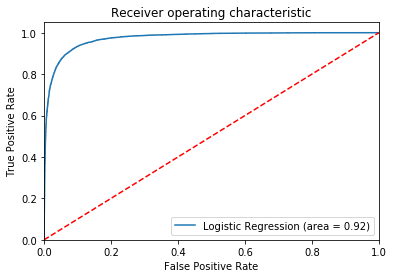

            words    weights
0         enjoyed  12.528268
1           loved  10.342144
2           great  10.009636
3             fun   9.483470
4          highly   8.651361
5       wonderful   8.445739
6      refreshing   8.367551
7            wait   7.985409
8       excellent   7.928282
9      disappoint   7.396052
10           well   7.286750
11      enjoyable   7.145678
12         hooked   7.109733
13           good   6.929708
14     pleasantly   6.874431
15          liked   6.683950
16        amazing   6.422943
17        awesome   6.347749
18      complaint   6.334661
19     delightful   6.111486
20            hot   6.043203
21      fantastic   5.923588
22         nicely   5.900055
23        perfect   5.769126
24          keeps   5.717291
25          waste -12.595429
26            not -11.857089
27         boring  -9.577699
28  disappointing  -9.033715
29        deleted  -8.995701
30     ridiculous  -8.807115
31  unfortunately  -8.688711
32         poorly  -8.499357
33        noth

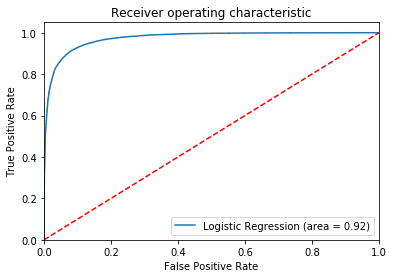

             words    weights
0            great   9.975116
1          perfect   9.062155
2        excellent   8.566733
3         favorite   8.565625
4        favorites   8.121383
5             best   7.601373
6           finest   7.588103
7          classic   7.496178
8       underrated   7.355476
9              gem   7.215590
10       wonderful   7.173756
11         amazing   7.037527
12       complaint   7.032293
13          hooked   6.509140
14      overlooked   6.410801
15       fantastic   6.366618
16           today   6.312415
17          superb   6.264393
18        captures   6.254796
19           solid   6.247856
20         awesome   6.208641
21          highly   6.185802
22           rocks   5.924771
23          brings   5.818927
24       beautiful   5.805269
25           worst -18.228800
26          boring -14.444700
27   disappointing -13.689636
28           awful -13.556426
29        horrible -12.335768
30  disappointment -12.284182
31      uninspired -12.241043
32        

In [12]:
import os
import gc
gc.collect()

os.listdir('/Volumes/GoogleDrive/Мой диск/Work/Experiment')

for i in os.listdir('/Volumes/GoogleDrive/Мой диск/Work/Experiment'):
    if i[-len('.json'):] == '.json' and i[-5:] != 'ipynb' and i[-3:] != 'csv': # and i == 'Health_and_Personal_Care_5.json': # and i = 'Health_and_Personal_Care_5.json':
        print (i[:-5])
        print ('   ')
        
        
        x,y = prepare_dataset ('/Volumes/GoogleDrive/Мой диск/Work/Experiment/' + i)
        
        classify_it ('/Volumes/GoogleDrive/Мой диск/Work/Experiment/' + i,x,y)
        
        del x
        del y
        
        gc.collect()
        

Comments

https://habr.com/ru/company/ods/blog/323890/#1-lineynaya-regressiya

https://docplayer.ru/28834116-Otchet-po-zadaniyu-4-issledovanie-modeli-logistic-regression.html

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_(%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9,_%D0%9A.%D0%92.%D0%92%D0%BE%D1%80%D0%BE%D0%BD%D1%86%D0%BE%D0%B2)#.D0.9E.D1.81.D0.BD.D0.BE.D0.B2.D0.BD.D1.8B.D0.B5_.D0.BF.D0.BE.D0.BD.D1.8F.D1.82.D0.B8.D1.8F_.D0.B8_.D0.BF.D1.80.D0.B8.D0.BC.D0.B5.D1.80.D1.8B_.D0.BF.D1.80.D0.B8.D0.BA.D0.BB.D0.B0.D0.B4.D0.BD.D1.8B.D1.85_.D0.B7.D0.B0.D0.B4.D0.B0.D1.87



ROC:
https://basegroup.ru/community/articles/logistic

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8